In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

import math

import pandas_datareader.data as web
from sklearn.metrics import mean_squared_error

In [2]:
#predcits stock prices by using machine learning models
def single_stock_data(symbol, start,end=None,plot=True,stock_value='Adj Close'):
    
    try:
        
        df = web.DataReader(symbol,'yahoo', start, end)
        df_single = pd.DataFrame(df)
        print("Dataframe has {} rows and {} columns".format(df_single.shape[0],df_single.shape[1]))
        print()
        if plot==True:
            plt.figure(figsize=(12,8))
            plt.plot(df_single[stock_value])
            label_font = {'weight':'bold','size':18}
            plt.xlabel('Date',fontdict=label_font)
            plt.ylabel('Close Price USD ($)',fontdict=label_font)
            plt.title(f'Historical {stock_value} Price for {symbol}',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
        return df_single
        
    except Exception as e:
        #if inccorect symbol is inputted, error message displayed
        print("Error occured/Incorrect Symbol:", e)
        #data = 'Incorrect Symbol'


Dataframe has 1077 rows and 6 columns



,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,758.760010,747.700012,757.919983,753.669983,3521100,753.669983
2017-01-04,759.679993,754.200012,758.390015,757.179993,2510500,757.179993
2017-01-05,782.400024,760.260010,761.549988,780.450012,5830100,780.450012
2017-01-06,799.440002,778.479980,782.359985,795.989990,5986200,795.989990
2017-01-09,801.770020,791.770020,798.000000,796.919983,3446100,796.919983
...,...,...,...,...,...,...
2021-04-08,3324.500000,3292.000000,3310.899902,3299.300049,2812100,3299.300049
2021-04-09,3372.199951,3288.899902,3304.699951,3372.199951,4334600,3372.199951
2021-04-12,3395.040039,3351.149902,3355.209961,3379.389893,3281800,3379.389893


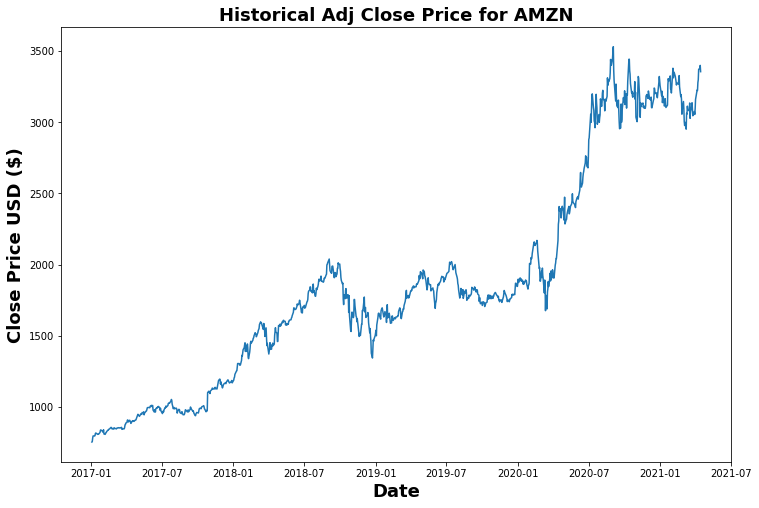

In [3]:
start='01-01-2017'
end='today'
stock = single_stock_data('AMZN', start= start,end='today',plot=True,stock_value='Adj Close')
stock

In [4]:
df = stock['Adj Close']
df

Date
2017-01-03     753.669983
2017-01-04     757.179993
2017-01-05     780.450012
2017-01-06     795.989990
2017-01-09     796.919983
                 ...     
2021-04-08    3299.300049
2021-04-09    3372.199951
2021-04-12    3379.389893
2021-04-13    3400.000000
2021-04-14    3355.959961
Name: Adj Close, Length: 1077, dtype: float64

In [5]:
#how many days do you want to predict out into the future
#this is 1 days out in the future
forecast_out=1 
#need a target variable that we want to predict
#use shift method to shift our data up the number of days taht we want to predcit into the future
#create the colun for target variable. Target is the dependent variable
#shifted 'n' units up
stock['Prediction'] = stock[['Adj Close']].shift(-1) #use negativ b/c we want to shift it up

In [6]:
stock.head()

,High,Low,Open,Close,Volume,Adj Close,Prediction
Date,,,,,,,
2017-01-03,758.760010,747.700012,757.919983,753.669983,3521100,753.669983,757.179993
2017-01-04,759.679993,754.200012,758.390015,757.179993,2510500,757.179993,780.450012
2017-01-05,782.400024,760.260010,761.549988,780.450012,5830100,780.450012,795.989990
2017-01-06,799.440002,778.479980,782.359985,795.989990,5986200,795.989990,796.919983
2017-01-09,801.770020,791.770020,798.000000,796.919983,3446100,796.919983,795.900024


In [7]:
stock_df = stock[['Adj Close','Prediction']]

In [8]:
#1/3 price was 26.65, if we want to predcit price by 1 day it would be 26.887.
#That's exactly what we got in Prediciton column 
#move up values by 1 day and put into prediciton column
stock_df

,Adj Close,Prediction
Date,,
2017-01-03,753.669983,757.179993
2017-01-04,757.179993,780.450012
2017-01-05,780.450012,795.989990
2017-01-06,795.989990,796.919983
2017-01-09,796.919983,795.900024
...,...,...
2021-04-08,3299.300049,3372.199951
2021-04-09,3372.199951,3379.389893
2021-04-12,3379.389893,3400.000000


In [9]:
#has NaN value at end
#if want to predcit next day of last value, we don't know what value is
#we will eliminate NaN
stock_df.tail()

,Adj Close,Prediction
Date,,
2021-04-08,3299.300049,3372.199951
2021-04-09,3372.199951,3379.389893
2021-04-12,3379.389893,3400.000000
2021-04-13,3400.000000,3355.959961
2021-04-14,3355.959961,NaN


In [10]:
stock['Prediction'] = stock[['Adj Close']].shift(-2) 

In [11]:
#what happends if we shifted up 2 days
#if price was 26.6533
#if we predcited 2 daya, then price would be 27.146002
stock

,High,Low,Open,Close,Volume,Adj Close,Prediction
Date,,,,,,,
2017-01-03,758.760010,747.700012,757.919983,753.669983,3521100,753.669983,780.450012
2017-01-04,759.679993,754.200012,758.390015,757.179993,2510500,757.179993,795.989990
2017-01-05,782.400024,760.260010,761.549988,780.450012,5830100,780.450012,796.919983
2017-01-06,799.440002,778.479980,782.359985,795.989990,5986200,795.989990,795.900024
2017-01-09,801.770020,791.770020,798.000000,796.919983,3446100,796.919983,799.020020
...,...,...,...,...,...,...,...
2021-04-08,3324.500000,3292.000000,3310.899902,3299.300049,2812100,3299.300049,3379.389893
2021-04-09,3372.199951,3288.899902,3304.699951,3372.199951,4334600,3372.199951,3400.000000
2021-04-12,3395.040039,3351.149902,3355.209961,3379.389893,3281800,3379.389893,3355.959961


In [12]:
#data is shifted up by 1 day
stock['Prediction'] = stock[['Adj Close']].shift(-forecast_out) 
stock

,High,Low,Open,Close,Volume,Adj Close,Prediction
Date,,,,,,,
2017-01-03,758.760010,747.700012,757.919983,753.669983,3521100,753.669983,757.179993
2017-01-04,759.679993,754.200012,758.390015,757.179993,2510500,757.179993,780.450012
2017-01-05,782.400024,760.260010,761.549988,780.450012,5830100,780.450012,795.989990
2017-01-06,799.440002,778.479980,782.359985,795.989990,5986200,795.989990,796.919983
2017-01-09,801.770020,791.770020,798.000000,796.919983,3446100,796.919983,795.900024
...,...,...,...,...,...,...,...
2021-04-08,3324.500000,3292.000000,3310.899902,3299.300049,2812100,3299.300049,3372.199951
2021-04-09,3372.199951,3288.899902,3304.699951,3372.199951,4334600,3372.199951,3379.389893
2021-04-12,3395.040039,3351.149902,3355.209961,3379.389893,3281800,3379.389893,3400.000000


In [13]:
forecast_out = 30
stock['Prediction'] = stock[['Adj Close']].shift(-forecast_out) 
stock

,High,Low,Open,Close,Volume,Adj Close,Prediction
Date,,,,,,,
2017-01-03,758.760010,747.700012,757.919983,753.669983,3521100,753.669983,842.700012
2017-01-04,759.679993,754.200012,758.390015,757.179993,2510500,757.179993,844.140015
2017-01-05,782.400024,760.260010,761.549988,780.450012,5830100,780.450012,845.070007
2017-01-06,799.440002,778.479980,782.359985,795.989990,5986200,795.989990,856.440002
2017-01-09,801.770020,791.770020,798.000000,796.919983,3446100,796.919983,855.609985
...,...,...,...,...,...,...,...
2021-04-08,3324.500000,3292.000000,3310.899902,3299.300049,2812100,3299.300049,NaN
2021-04-09,3372.199951,3288.899902,3304.699951,3372.199951,4334600,3372.199951,NaN
2021-04-12,3395.040039,3351.149902,3355.209961,3379.389893,3281800,3379.389893,NaN


In [14]:
#create independt data set, X
#a list of list
X = np.array(stock['Adj Close']).reshape(-1, 1)
#remove the last 'n' values which are nan
X = X[:-forecast_out]

In [15]:
X

array([[ 753.66998291],
       [ 757.17999268],
       [ 780.45001221],
       ...,
       [3092.92993164],
       [3146.13989258],
       [3094.5300293 ]])

In [16]:
#create the dependent dataset
#gives all values including NaNs
y = np.array(stock['Prediction']).reshape(-1, 1)
#get all of y values except fpr last n rows
#y is now a numpy array
y =y[:-forecast_out]
y

array([[ 842.70001221],
       [ 844.14001465],
       [ 845.07000732],
       ...,
       [3379.38989258],
       [3400.        ],
       [3355.95996094]])

In [17]:
#split data, 80% train and 20 testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
#create and train SVM(support vector machine) algorithm (regressor)
#vector regressor
svr_rbf = SVR(kernel='rbf', C=1e3, gamma= 0.1)
#train model, inpu training data
svr_rbf.fit(X_train,y_train)

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVR(C=1000.0, gamma=0.1)

In [19]:
from sklearn.svm import SVR

In [20]:
#test how good model is
#score returns the coeficient of determination R2 of hte prediction
#the best possible score is 1.0
svm_confidence = svr_rbf.score(X_test,y_test)
print('svm Confidence: ',svm_confidence)

svm Confidence:  0.7915578600335


In [21]:
#creae and train linear regession model
lr = LinearRegression() 
lr.fit(X_train,y_train)

LinearRegression()

In [22]:
#test linear regression mdoe
lr_confidence = lr.score(X_test,y_test)
print('svm Confidence: ',lr_confidence)

svm Confidence:  0.9436150619982732


In [23]:
#create values that we want t oforecast on
#set x_forecast = last 30 rows of teh orignail dataset from adjusted close price
#gives last 30 rows of data
x_forecast = np.array(stock['Adj Close']).reshape(-1, 1)[-forecast_out:]
x_forecast

array([[3005.        ],
       [2977.57006836],
       [3000.45996094],
       [2951.94995117],
       [3062.85009766],
       [3057.63989258],
       [3113.59008789],
       [3089.48999023],
       [3081.67993164],
       [3091.86010742],
       [3135.72998047],
       [3027.98999023],
       [3074.95996094],
       [3110.87011719],
       [3137.5       ],
       [3087.07006836],
       [3046.26000977],
       [3052.0300293 ],
       [3075.72998047],
       [3055.29003906],
       [3094.08007812],
       [3161.        ],
       [3226.72998047],
       [3223.82006836],
       [3279.38989258],
       [3299.30004883],
       [3372.19995117],
       [3379.38989258],
       [3400.        ],
       [3355.95996094]])

In [24]:
#look at predictions
#predicitons for nexrt 'n' days
#what lr model thinks price will be for next 30 daya based on x_forecast data
#values that model predicted
lr_prediction = lr.predict(x_forecast)
print(lr_prediction)

#what support vector regressor model thinks adj close price will be for next 30 days
#predicting stock prices in the future
#what it thinks price will be 30 days from now
svm_prediction = svr_rbf.predict(x_forecast)
print(svm_prediction)

[[3062.19619321]
 [3035.09998294]
 [3057.71138972]
 [3009.79156833]
 [3119.34246798]
 [3114.19565193]
 [3169.46513918]
 [3145.65825106]
 [3137.94321215]
 [3147.99953264]
 [3191.33567071]
 [3084.90647983]
 [3131.30499877]
 [3166.77826051]
 [3193.08415561]
 [3143.26777073]
 [3102.95422043]
 [3108.65404005]
 [3132.06565   ]
 [3111.87438749]
 [3150.19249446]
 [3216.29824706]
 [3281.22853545]
 [3278.35402627]
 [3333.24777014]
 [3352.91569302]
 [3424.92867172]
 [3432.03113799]
 [3452.39049622]
 [3408.88626243]]
[2485.15693043 2093.21235984 3255.87657352 2092.94131206 2127.09827835
 3092.10228562 3135.96394283 2397.30751628 3060.95195911 3123.7513231
 3263.04119307 2100.03706252 2115.6649913  3189.73417803 3285.37799609
 2151.0312935  2133.43029188 3125.4814424  2148.22013922 3127.12760122
 3411.7762601  3095.47831928 2713.39918431 2996.29011238 2834.22972439
 2242.64458627 2267.23291036 3056.36117483 3286.54993126 2325.08042694]


In [29]:
def plot_predictions(model_pred,data,X,model):
    predictions =  model_pred     #lr_prediction
    #val is actual values
    valid = data[X.shape[0]: ]
    valid['Predictions'] = predictions
    plt.figure(figsize=(12,8))
    plt.title(f'Model: {model}')
    plt.xlabel('Dates')
    plt.ylabel('Stock Price')
    plt.plot(stock['Adj Close'])
    plt.plot(valid[['Adj Close','Predictions']])
    plt.legend(['Orig','Valid,','Predictions']) #predcited-predicted value of model


/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


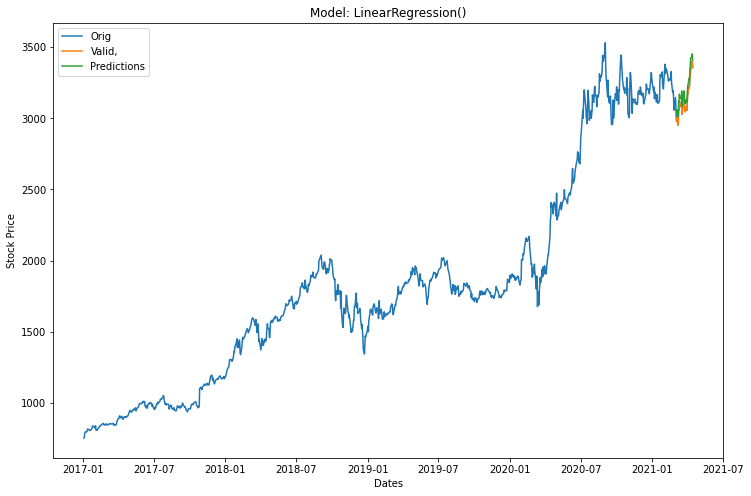

In [30]:
plot_predictions(lr_prediction,stock,X,lr)

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


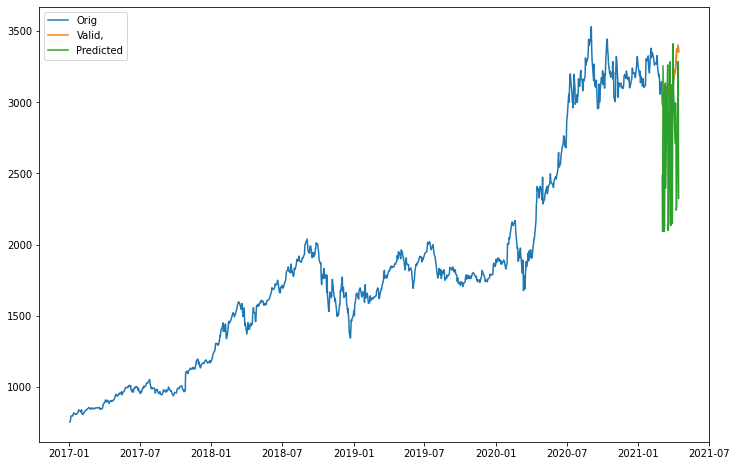

In [27]:
predictions_2 = svm_prediction

valid_1 = stock[X.shape[0]: ] #X.shape[0]
valid_1['Predictions'] = predictions_2
plt.figure(figsize=(12,8))
plt.plot(stock['Adj Close'])
plt.plot(valid_1[['Adj Close','Predictions']])
plt.legend(['Orig','Valid,','Predicted']) #predcited-predicted value of model


In [28]:
X.shape

(1047, 1)